# Imports 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from PIL import Image
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import time
import random

In [3]:
random.seed(42) # For reproductibility

# Functions

These functions will make computations easier. They are inspired by the articles.

In [4]:
def delta(x,i,class_num):
    '''
    Function that selects the coefficients associated with the ith class
    Useful for SCI calculation
    '''
    n,m = len(x),len(class_num)
    
    if (n != m):
        print('Vectors of differents sizes')
        
    tmp = i*np.ones(n)-class_num

    for k in range(n):
        if tmp[k]==0:
            tmp[k]=1
        else:
            tmp[k]=0 
            
    return tmp*x

In [5]:
def residual(y,A,x,class_x):
    '''
    Returns the class which minimizes the reconstruction error following the norm 2
    '''
    k = np.max(class_x)+1
    r = np.zeros(k)
    
    for i in range(0,k):
        r[i] = np.linalg.norm(y - np.dot(A,delta(x,i,class_x)))
        
    return r

The SCI function implements the Sparsity Concentration Index (with $k$ number of classes and $\delta_{i}$ the indicator of i-th class)  :

$$SCI(x)=\frac{k*max_i  \frac{\|\delta_{i}(x)\|_{1}}{\|x\|_{1}}-1}{k-1}$$

It is used to filter out bad images.

In [6]:
def SCI(x,class_num):
    '''
    - class_num: classe of a training element.
    - x        : sparse coefficients
    '''
    
    k = len(set(class_num)) # Number of different classes
    
    return (k*(1/np.linalg.norm(x,ord=1))*np.max([np.linalg.norm(delta(x,i,class_num),ord=1) for i in range(k)]) - 1)/(k-1)
    

Then we have to read all the images :

In [7]:
def read_images(path, sz=None, sz0=120, sz1=165):
    '''
    Sizes must be changed depending on the pictures analyzed
    Resizing is possible with 'sz'
    '''
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for filename in os.listdir(path):
            try:
                im = Image.open(os.path.join(path , filename)) 
                im = im.convert("L")
                # resize to given size (if given) and check that it's the good size
                if ((im.size[0] == sz0) & (im.size[1]==sz1)):
                    if (sz is not None):
                        im = im.resize(sz, Image.NEAREST)
                        X.append(np.asarray(im, dtype=np.uint8))
                        c = int(filename[2:5]) - 1
                        y.append(c)
            except IOError:
                pass
            except:
                print("Unexpected error:", sys.exc_info()[0])
                raise

    print("Images uploaded !")
    return [X,y]

The following function add noise to an image. Given a amount of pixel to corrupt, it replace the pixel with a random pixel between 0 and 256.

# Upload images : feature reduction to chose

You can choose those following feature reduction :

* reduced_fs_dimension : classic dimension reduction
* fisherfaces
* eigenfaces
* randomfaces

In [8]:
mode_reduc_features = 'fisherfaces'
size_features = (30,42) #(30,42) #Important later for feature reduction
path_images = 'C:/Users/User/Documents/Compressed Sensing/AR Database/AR_warp_zip/test2/' # Pictures should be in here

n_components = size_features[0]*size_features[1]

print("Chosen reduction feature : ", mode_reduc_features)

Chosen reduction feature :  fisherfaces


** Upload images **

120 165


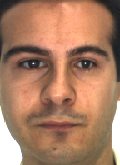

In [9]:
im = Image.open(path_images+"M-001-01.bmp")

print(im.size[0],im.size[1])

im

In [10]:
# Here are the original pictures, so we can see at the end the transformations

X_original, y_original = read_images(path_images, sz=(120,165))

Images uploaded !


In [11]:
# Or load here resized, or something else

if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images(path_images, sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images(path_images, sz=(30,42))
else :
    X, y = read_images(path_images, sz=(30,42))

Images uploaded !


In [12]:
print("Number of pictures loaded",len(X))

Number of pictures loaded 1300


## Separation train/test

Each person has 26 images, corresponding to two sessions of 13 pictures :

* 8 frontal images
* 6 with varying luminosity
* 6 with sun glasses and varying luminosity
* 6 with occlusion (scarf) and varying luminosity

First, we consider the first session as train. We will test our algorithm on 4 training frontal images of the second session, with the equivalent pictures of the first session as train.

Then, we will use both session pictures (8 in total) as train in order to test images with varying luminosity in both sessions, then with sunglasses and finally with scarves.  

In [13]:
X_train, X_test  = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if (i%26 in range(1,5)) or (i%26 in range(14,18)) : # condition on i for the train images
        X_train.append(X[i])
        ytrain.append(y[i])
        indices_train.append(i)
    else:
        X_test.append(X[i])
        ytest.append(y[i])
        indices_test.append(i)

Then we stack the images into vectors and concatenate them.

In [14]:
def stack(X_train,X_test):
    X_toconcat_train = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_train]
    X_toconcat_test = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_test]
    
    Xtrain = np.concatenate(X_toconcat_train,axis=1) # Each column is now an image of the train set
    Xtest = np.concatenate(X_toconcat_test,axis=1) # Each column is now an image of the test set

    return Xtrain,Xtest

In [15]:
Xtrain, Xtest = stack(X_train,X_test)

## Feature reduction

We can here use reduction methods from the **features_reduction.py** program (Eigenfaces, Fisherfaces...)

In [16]:
from features_reduction import *

We can Normalise the data.

In [17]:
def feature_reduction(Xtrain,Xtest,mode_reduc_features):
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    Xtrain = ss.fit_transform(Xtrain)
    Xtest = ss.fit_transform(Xtest)
    
    if (mode_reduc_features == 'eigenfaces'):
        Xtrain, Xtest = eigenfaces(Xtrain.T,Xtest.T,n_components=n_components)
        Xtrain, Xtest = Xtrain.T, Xtest.T
    elif (mode_reduc_features == 'fisherfaces'):
        Xtrain, Xtest = fisherfaces(Xtrain.T,ytrain,Xtest.T,n_components=n_components)
        Xtrain, Xtest = Xtrain.T, Xtest.T
    elif (mode_reduc_features == 'randomfaces'):
        Xtrain, Xtest = randomfaces(Xtrain.T, Xtest.T, n_components=n_components)
        Xtrain, Xtest = Xtrain.T, Xtest.T    
        
    return Xtrain, Xtest

Transpose is important for the feature_reduction to work.

In [18]:
Xtrain, Xtest = feature_reduction(Xtrain,Xtest,mode_reduc_features)

print('Size of the new dataset',Xtrain.shape)

Extracting the top 1260 Fisherfaces from 400 faces
done in 0.101s
Projecting the input data on the fisher orthonormal basis
Fisherfaces done in 0.016s
Size of the new dataset (49, 400)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


# Whole Algorithm Commented (we will use only one function instead of pasting as many times as there are test sets)


Here we implement the algorithm 1 of the paper (relaxed version)
	
- Input : a matrix of training samples $A=\lbrack A_{1},A_{2},...,A_{k} \rbrack \in \mathbb{R}^{m \times n}$ for k classes and a test sample $y \in \mathbb{R}^{m}$
- Normalize the columns of A to have unit $L^{2}$ norm
- Solve the $L^{1}$ minimization problem : $\hat{x_{1}}= argmin \|x\|_{1}$   sc  $\|Ax-y\|_{2} \leq \epsilon$		
- Compute the residuals
	$ \mbox{ for all } i=1,...k, r_{i}(y)=\|y-A\delta_{i}(\hat{x_{1}})\|_{2}$
	
- $\mathcal{C}_{y}=argmin_{i} r_{i}(y)$
	

In [19]:
from sklearn.linear_model import Lasso

We have seen in the papers that the minimization problem is equivalent to the LASSO problem.

# Example

Test_pic varies, it depends what the test set is (sunglasses, scarves, ...)

In [20]:
test_pic = 0

In [21]:
clf = Lasso(alpha=4)

y = Xtest[:,test_pic]

clf.fit(Xtrain,y)
x = clf.coef_

** Results **

In [22]:
pred_class = np.argmin(residual(Xtest[:,test_pic],Xtrain,x,ytrain))

In [23]:
print("Real class: ", ytest[test_pic])
print("Predicted class: ", pred_class)
print("SCI : ", SCI(x,ytrain))

Real class:  0
Predicted class:  0
SCI :  1.0


Text(0.5,0,'Image')

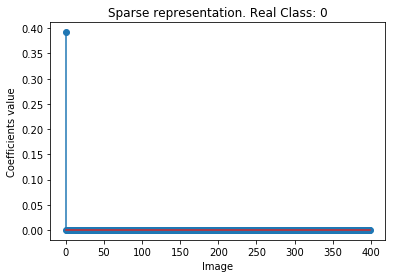

In [24]:
plt.figure()
plt.stem(x)
plt.title('Sparse representation. Real Class: ' + str(ytest[test_pic]))
plt.ylabel('Coefficients value')
plt.xlabel('Image')

We see that the solution is really really sparse, that's work !

### Residuals

Text(0.5,0,'Class')

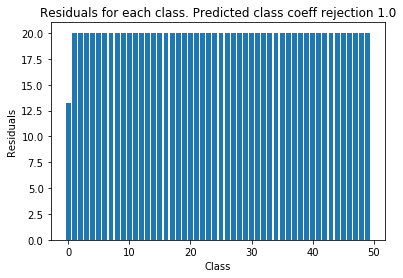

In [25]:
plt.figure()
plt.clf()
plt.bar(range(50),residual(Xtest[:,test_pic],Xtrain,x,ytrain))
plt.title('Residuals for each class. Predicted class coeff rejection ' + str(np.round(SCI(x,ytrain),2)))
plt.ylabel('Residuals')
plt.xlabel('Class')

As well the SCI makes a very clear difference between all the classes

### Image reconstruction

Here we get the original images and the coeff of selected image with the sparse representation and we reconstruct our image 

** Original **

In [26]:
i_original = indices_test[test_pic] #We take the original photo, not transformed in any way

try:
    X_toconcat_original = [np.reshape(e,(X_original[0].shape[0]*X_original[0].shape[1],1)) for i,e in enumerate(X_original)]
except:
    print(e.shape)
    plt.imshow(X_original[i], cmap='gray')

Xoriginal = np.concatenate(X_toconcat_original,axis=1)

** Error on image **

In [27]:
error_recomposition = np.reshape(np.dot(Xoriginal[:,indices_train],x),
                                  (X_original[i_original].shape[0],X_original[i_original].shape[1]))    

** Print recomposed image with just the predicted class **

In [28]:
face_recomposed = np.reshape(np.dot(Xoriginal[:,indices_train],
                                    delta(x,pred_class,ytrain)),(X_original[i_original].shape[0],X_original[i_original].shape[1]))

Text(0.5,1,'Error')

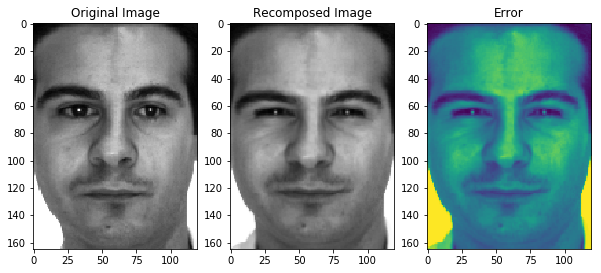

In [29]:
plt.figure(figsize=(10,12))
plt.clf()
plt.subplot(1,3,1)
plt.imshow(X_original[i_original], cmap='gray')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(face_recomposed, cmap='gray')
plt.title('Recomposed Image')
plt.subplot(1,3,3)
plt.imshow(error_recomposition)
plt.title('Error')

We then write a program that enables us to check if a test image is well classed or not :

In [30]:
def FaceClass(test_pic,alpha):

    clf = Lasso(alpha=alpha)

    y = Xtest[:,test_pic]

    clf.fit(Xtrain,y)
    x = clf.coef_

    pred_class = np.argmin(residual(Xtest[:,test_pic],Xtrain,x,ytrain))

    print("Test class: ", ytest[test_pic])
    print("Predicted class: ", pred_class)
    print("SCI: ", SCI(x,ytrain))

    plt.figure()
    plt.stem(x)
    plt.title('Sparse representation. Real Class: ' + str(ytest[test_pic]))
    plt.ylabel('Coefficients value')
    plt.xlabel('Image')

    plt.figure()
    plt.clf()
    plt.bar(range(50),residual(Xtest[:,test_pic],Xtrain,x,ytrain))
    plt.title('Residuals for each class. Predicted class coeff rejection ' + str(np.round(SCI(x,ytrain),2)))
    plt.ylabel('Residuals')
    plt.xlabel('Class')

    i_original = indices_test[test_pic] 

    try:
        X_toconcat_original = [np.reshape(e,(X_original[0].shape[0]*X_original[0].shape[1],1)) for i,e in enumerate(X_original)]
    except:
        print(e.shape)
        plt.imshow(X_original[i], cmap='gray')

    Xoriginal = np.concatenate(X_toconcat_original,axis=1) 

    error_recomposition = np.reshape(np.dot(Xoriginal[:,indices_train],x),(X_original[i_original].shape[0],X_original[i_original].shape[1]))    

    face_recomposed = np.reshape(np.dot(Xoriginal[:,indices_train],delta(x,pred_class,ytrain)),(X_original[i_original].shape[0],X_original[i_original].shape[1]))

    plt.figure(figsize=(10,12))
    plt.clf()
    plt.subplot(1,3,1)
    plt.imshow(X_original[i_original], cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(face_recomposed, cmap='gray')
    plt.title('Recomposed Image')
    plt.subplot(1,3,3)
    plt.imshow(error_recomposition)
    plt.title('Error')
    
    if ytest[test_pic] == pred_class:
        return "Good Prediction"
    else: 
        return "Wrong Prediction"
    

In [31]:
def FaceClass_noplot(test_pic,alpha):
    clf = Lasso(alpha=alpha)

    y = Xtest[:,test_pic]

    clf.fit(Xtrain,y)
    x = clf.coef_

    pred_class = np.argmin(residual(Xtest[:,test_pic],Xtrain,x,ytrain))

    if ytest[test_pic] == pred_class:
        return "Good Prediction"
    else: 
        return "Wrong Prediction"

We shall run our code on the test images with no noise, no occlusions, but with light variance.

Test class:  0
Predicted class:  0
SCI:  0.09148118619756863


'Good Prediction'

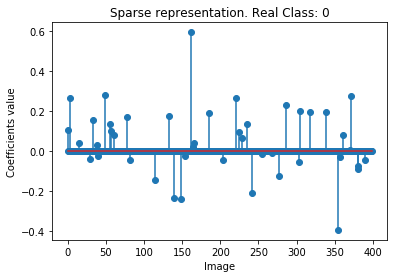

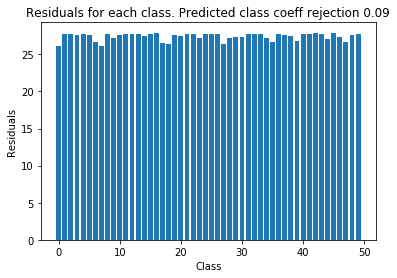

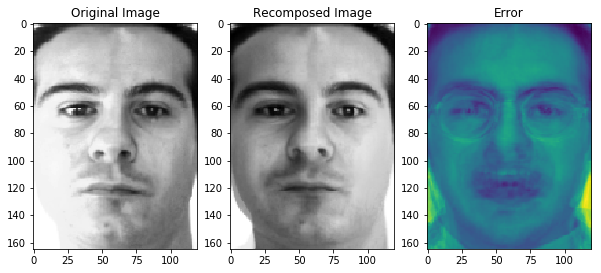

In [32]:
test_pic = 1

FaceClass(test_pic,0.1)

Test class:  0
Predicted class:  18
SCI:  0.10009420214855243


'Wrong Prediction'

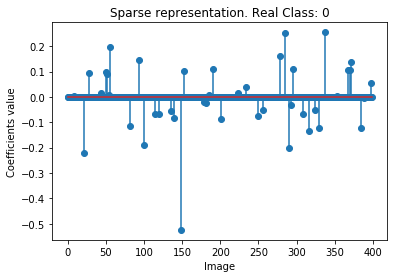

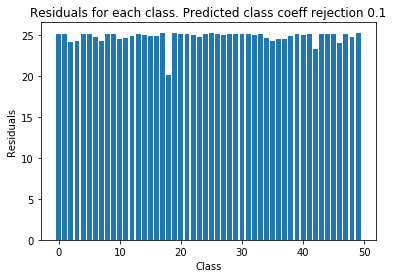

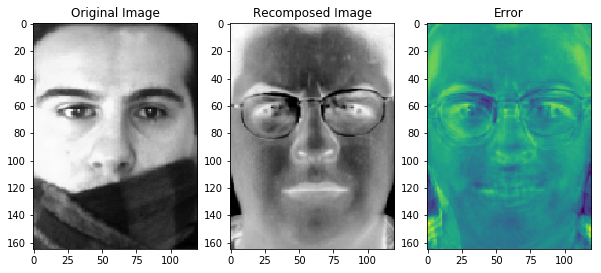

In [33]:
FaceClass(8,0.1)

# Now we try on the different tests sets

# Frontal Images

This part is using the first session as the train (4 normal frontal images) and testing it on the second session.

In [34]:
mode_reduc_features = 'fischerfaces'
size_features = (30,42)

X_original, y_original = read_images(path_images, sz=(120,165))

if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images(path_images, sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images(path_images, sz=(30,42))
else :
    X, y = read_images(path_images, sz=(30,42))

X_train, X_test  = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if i%26 in range(1,5) : # condition on i for the train images for the first session
        X_train.append(X[i])
        ytrain.append(y[i])
        indices_train.append(i)
    if i%26 in range(14,18): # condition on i for the test images, those of the second sessions
        X_test.append(X[i])
        ytest.append(y[i])
        indices_test.append(i)
        

Xtrain, Xtest = stack(X_train,X_test)

Xtrain, Xtest = feature_reduction(Xtrain,Xtest,mode_reduc_features)

Images uploaded !
Images uploaded !


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Test class:  3
Predicted class:  3
SCI:  0.8493407310214592


'Good Prediction'

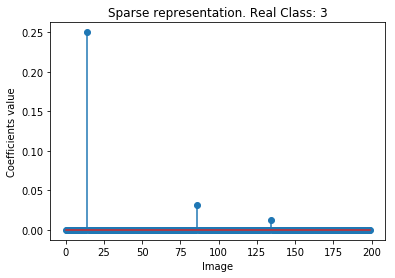

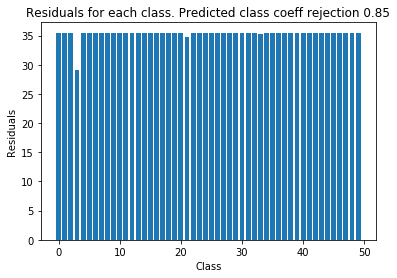

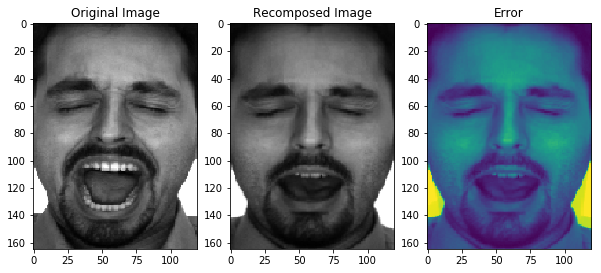

In [35]:
test_pic = 14

FaceClass(test_pic,0.5)

Test class:  45
Predicted class:  45
SCI:  0.07439246502561836


'Good Prediction'

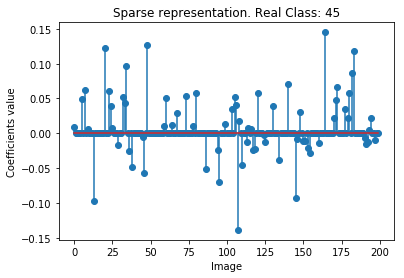

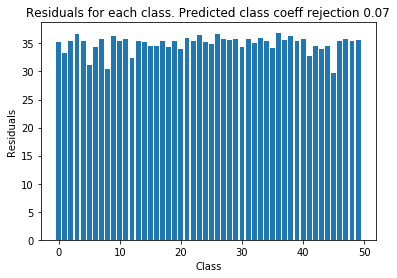

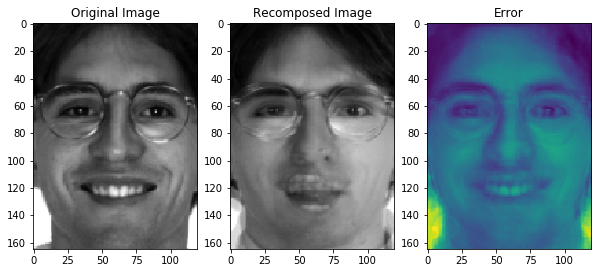

In [36]:
FaceClass(180,0.01)

In [37]:
#liste = []

#for alpha in range(1,180,1):
#    alpha = alpha/100
total = 0

for i in range(Xtest.shape[1]):
    #res = FaceClass_noplot(i,alpha)
    res = FaceClass_noplot(i,0.01)
    if res == 'Good Prediction':
        total+=1
        
print('Test Score : %s' %(total/(Xtest.shape[1]))) 
#    tot = total/(Xtest.shape[1])
#    liste.append(tot)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test Score : 0.905


90.5% sucess on the test !

Without the comments, we get the code used for cross validation, which helps us find the good constant, maximising our recognition rate.

Let's have a look on the pictures that aren't well recognize :

Test class:  1
Predicted class:  17
SCI:  0.12579980552245418


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


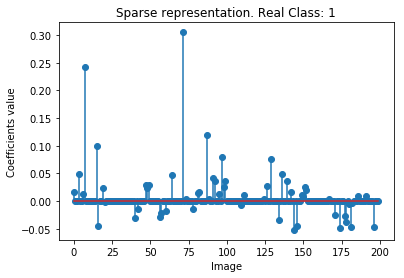

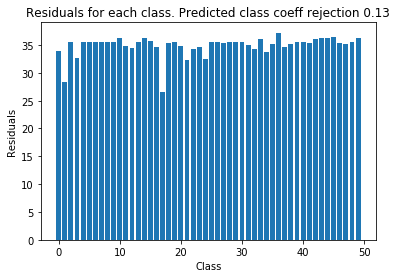

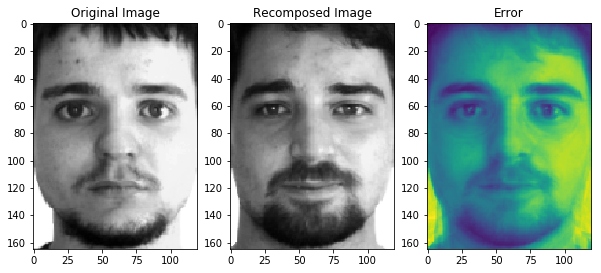

In [38]:
for i in range(Xtest.shape[1]):
    res = FaceClass_noplot(i,0.01)
    if res != 'Good Prediction':
        if i < 10:
            FaceClass(i,0.01)

First of all, we notice that the people our algorithm doesn't recognize actually look alike with the person in the suggested image. Most of them have similar beards and face structure. Then, we notice that in the Sparse Representation that the correct picture has a high coefficient, but which isn't the highest. This can be explained by our algorithm trying to find the most significant images; certainly it finds the correct subject, but it also recovers pictures from others having certain similarities. For example, a person with a smirk that is different in both sessions won't be recognized, and the code will output the image of someone similar in features (beard, etc...), but with the same smirk.

It would be interesting to test with twins ! And of course, more training images.

## Now with different lighting

In [39]:
mode_reduc_features = 'fisherfaces'
size_features = (30,42)

X_original, y_original = read_images(path_images, sz=(120,165))

if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images(path_images, sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images(path_images, sz=(30,42))
else :
    X, y = read_images(path_images, sz=(30,42))

X_train, X_test  = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if (i%26 in range(0,4)) or (i%26 in range(13,17)): # condition on i for the train images for the first session
        X_train.append(X[i])
        ytrain.append(y[i])
        indices_train.append(i)
    if (i%26 in range(4,7)) or (i%26 in range(17,20)): # condition on i for the test images, those of the second sessions
        X_test.append(X[i])
        ytest.append(y[i])
        indices_test.append(i)
        

Xtrain, Xtest = stack(X_train,X_test)

Xtrain, Xtest = feature_reduction(Xtrain,Xtest,mode_reduc_features)

Images uploaded !
Images uploaded !
Extracting the top 1260 Fisherfaces from 400 faces
done in 0.083s
Projecting the input data on the fisher orthonormal basis
Fisherfaces done in 0.000s


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Test class:  20
Predicted class:  20
SCI:  0.20135807832680971


'Good Prediction'

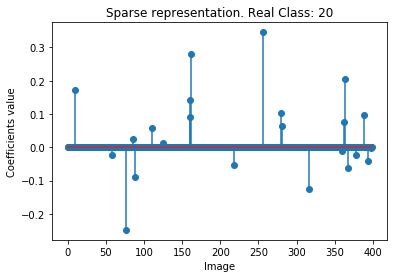

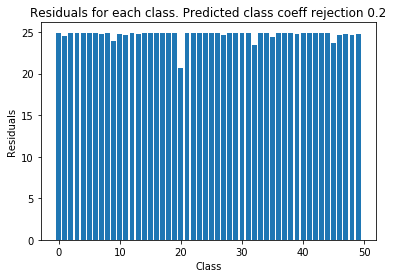

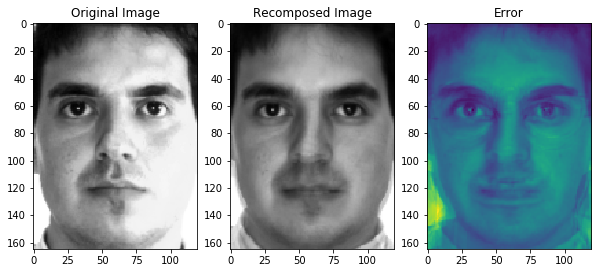

In [40]:
test_pic = 120


FaceClass(test_pic,1)

In [41]:
#liste = []

#for alpha in range(1,100,1):
#    alpha = alpha/100
total = 0

for i in range(Xtest.shape[1]):
    #res = FaceClass_noplot(i,alpha)
    res = FaceClass_noplot(i,0.01)
    if res == 'Good Prediction':
        total+=1
        
print('Test Score : %s' %(total/(Xtest.shape[1]))) 
#    tot = total/(Xtest.shape[1])
#    liste.append(tot)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test Score : 0.6466666666666666


Less recognition then. 65.3%, that's 25 points less than without the lighing variation.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test class:  0
Predicted class:  0
SCI:  0.09121868278290199
Test class:  1
Predicted class:  1
SCI:  0.15638130717475235
Test class:  1
Predicted class:  1
SCI:  0.16220237745890756
Test class:  2
Predicted class:  2
SCI:  0.10385234041560036
Test class:  2
Predicted class:  2
SCI:  0.09871751882959112


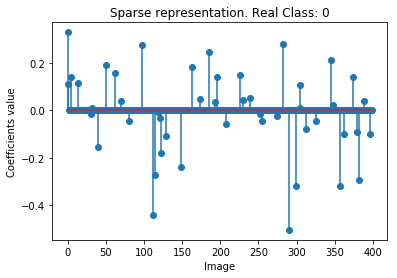

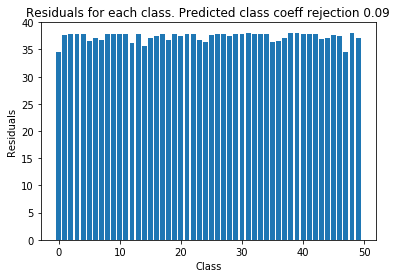

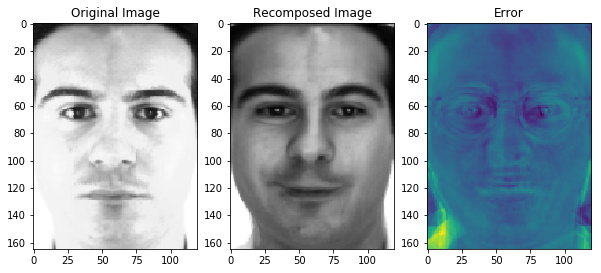

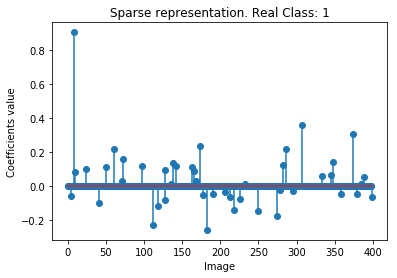

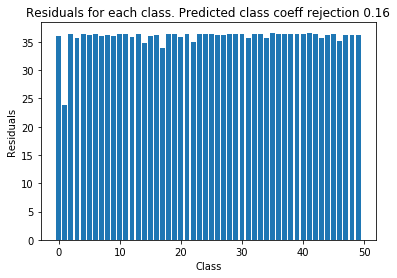

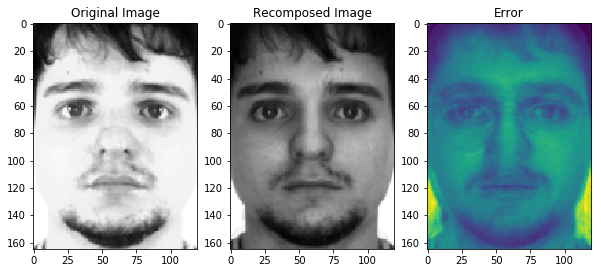

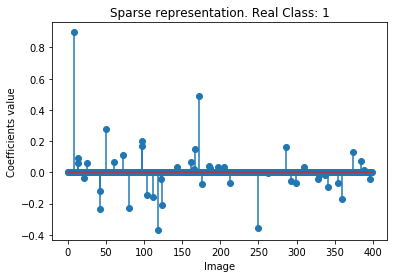

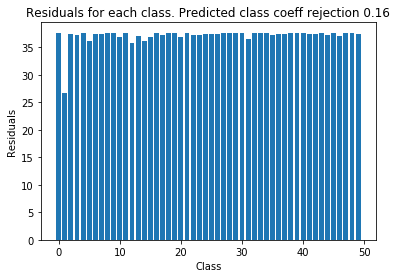

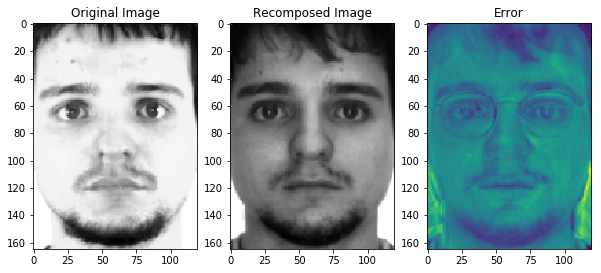

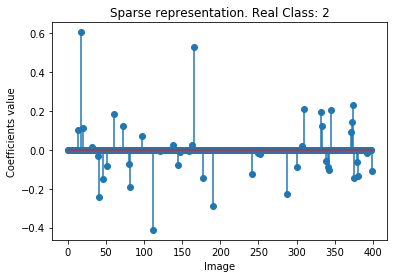

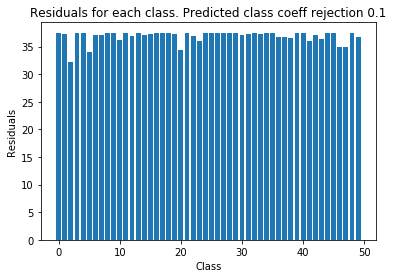

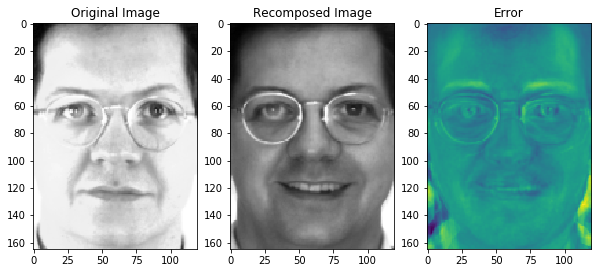

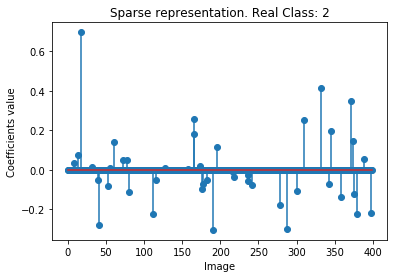

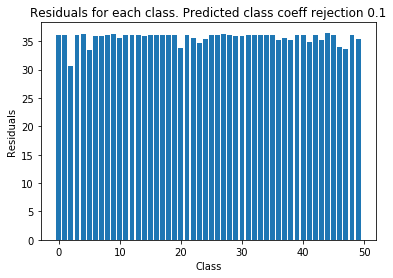

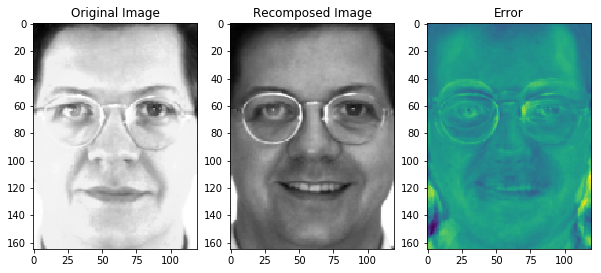

In [42]:
for i in range(Xtest.shape[1]):
    res = FaceClass_noplot(i,0.14)
    if res == 'Good Prediction':
        if (i%3 == 2) and i <20: # In order to see the pictures with a lot of light
            FaceClass(i,0.14)

What is interesting is that using a low constant gives good results for some pictures, but for others it's a higher value that yields good results.

It would be interesting to see the difference if we add just one picture with more light in the data set.

Our conclusion here is that too much light makes the program find pictures that when mixed together give a "white-effect". This could explain the lower score of 65.3 %.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test class:  0
Predicted class:  47
SCI:  0.09245789422562034


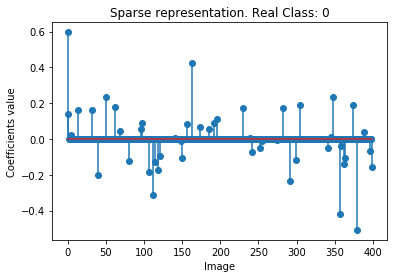

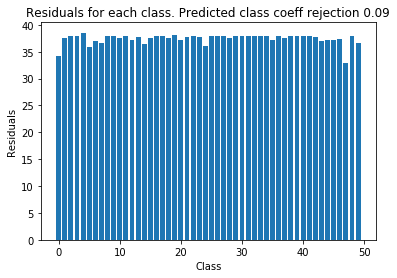

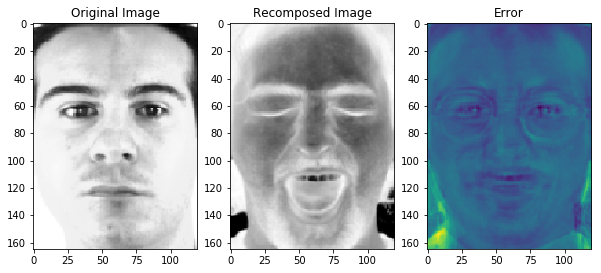

In [43]:
for i in range(Xtest.shape[1]):
    res = FaceClass_noplot(i,0.14)
    if res != 'Good Prediction':
        if (i%3 == 2) and i <20: # In order to see the pictures with a lot of light
            FaceClass(i,0.14)

Just like in the pictures above, light variation can be simulated by having many different pictures with different luminosity. We have this X-Ray effect of using several images with approximates well the images with a lot of light.

## Now with sunglasses

In [44]:
mode_reduc_features = 'fisherfaces'
size_features = (30,42)

X_original, y_original = read_images(path_images, sz=(120,165))

if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images(path_images, sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images(path_images, sz=(30,42))
else :
    X, y = read_images(path_images, sz=(30,42))

X_train, X_test  = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if (i%26 in range(0,4)) or (i%26 in range(13,17)): # condition on i for the train images for the first session
        X_train.append(X[i])
        ytrain.append(y[i])
        indices_train.append(i)
    #if (i%26 in range(7,10)) or (i%26 in range(20,23)): # condition on i for the test images, those of the second sessions
    if i%26 in [7,20]:
        X_test.append(X[i])
        ytest.append(y[i])
        indices_test.append(i)
        

Xtrain, Xtest = stack(X_train,X_test)

Xtrain, Xtest = feature_reduction(Xtrain,Xtest,mode_reduc_features)

Images uploaded !
Images uploaded !
Extracting the top 1260 Fisherfaces from 400 faces
done in 0.096s
Projecting the input data on the fisher orthonormal basis
Fisherfaces done in 0.000s


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Test class:  40
Predicted class:  40
SCI:  0.14516390670387683


'Good Prediction'

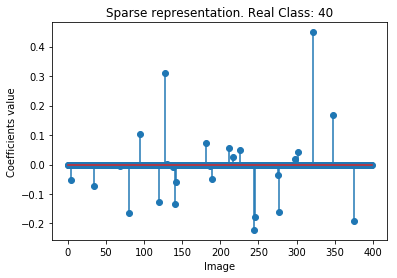

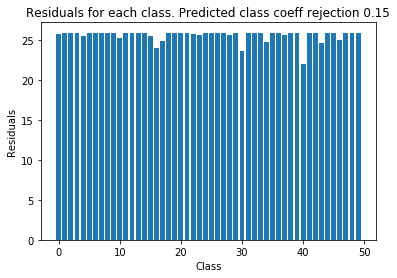

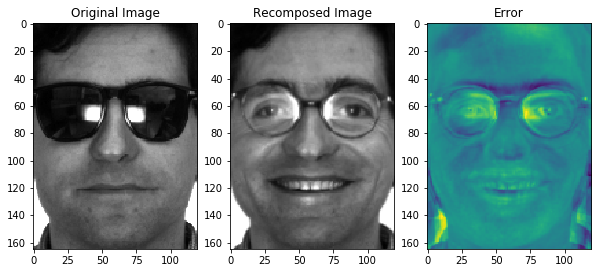

In [45]:
test_pic = 80


FaceClass(test_pic,0.75)

In [46]:
#liste = []

#for alpha in range(100,200,1):
#    alpha = alpha/100
total = 0

for i in range(Xtest.shape[1]):
    #    res = FaceClass_noplot(i,alpha)
    res = FaceClass_noplot(i,0.01)
    if res == 'Good Prediction':
        total+=1
        
print('Test Score : %s' %(total/(Xtest.shape[1]))) 
#    tot = total/(Xtest.shape[1])
#    liste.append(tot)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test Score : 0.48


With all the pictures we get 50% recognition rate. But if we add light variation, we get 34.3%, which isn't a good score, but on the other hand we've seen that lighting differences decreases the end results. Let's see what the bad score look like :

Test class:  0
Predicted class:  30
SCI:  0.14010339359983398
Test class:  0
Predicted class:  48
SCI:  0.1469623104042976
Test class:  2
Predicted class:  30
SCI:  0.16815521034848604


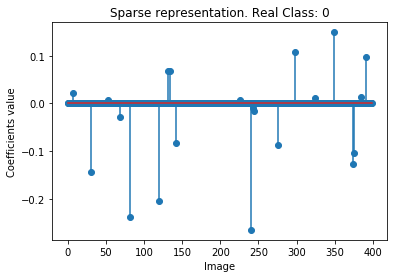

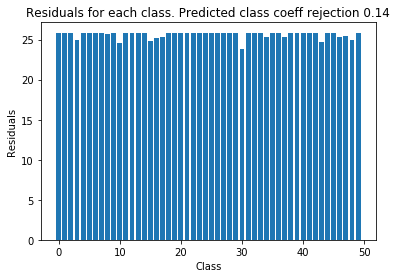

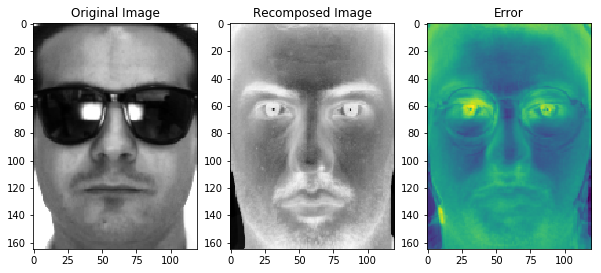

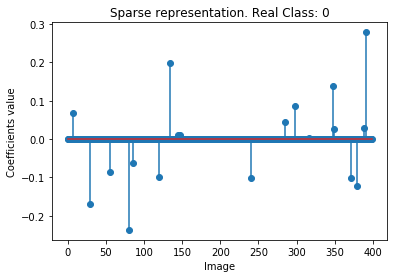

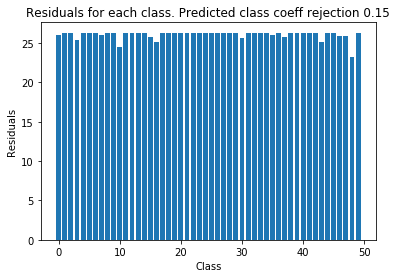

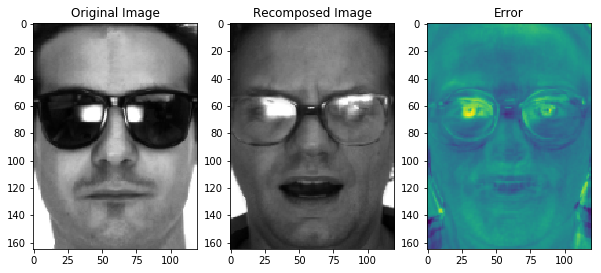

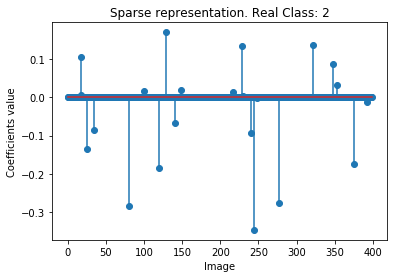

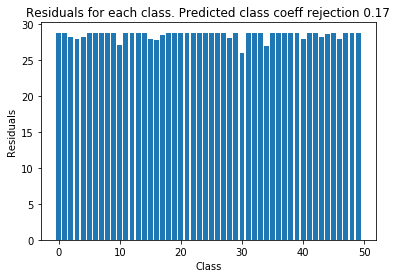

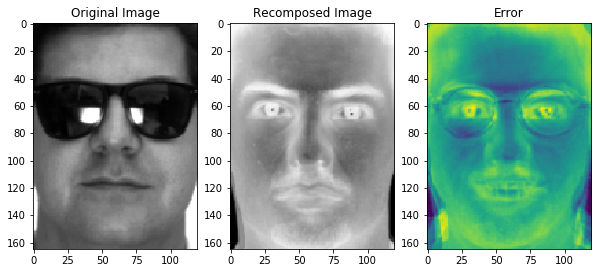

In [47]:
for i in range(Xtest.shape[1]):
    res = FaceClass_noplot(i,1.48)
    if res != 'Good Prediction':
        if (i < 5) or (i>195):
            FaceClass(i,1.48)

Results are nos satisfying here. Not only with different lighting pictures couldn't be well recognized earlier, but if we add sunglasses the success rate decreases drastically. It's like adding the X-ray effect mentionned earlier to the problem of adding sunglasses to the subjects. As a consequence, we noticed that the predicted classes tend to be those of men who initially wear glasses.

It would be interesting to run the tests without anyone who wears glasses, results could increase in that case. We can also suggest to wear different sunglasses for the testing sessions. Perhaps also we could test on only pictures taken without lighting variation, since previsouly we saw our algorithm is only correct twice out of three, instead of 9 times out of 10. We therefore increase the probability of being wrong if we add sunglasses and take a picture with high luminosity. 

# Now with scarves

In [48]:
mode_reduc_features = 'fisherfaces'
size_features = (30,42)

X_original, y_original = read_images(path_images, sz=(120,165))

if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images(path_images, sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images(path_images, sz=(30,42))
else :
    X, y = read_images(path_images, sz=(30,42))

X_train, X_test  = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if (i%26 in range(0,4)) or (i%26 in range(13,17)): # condition on i for the train images for the first session
        X_train.append(X[i])
        ytrain.append(y[i])
        indices_train.append(i)
    #if (i%26 in range(10,13)) or (i%26 in range(23,26)): # condition on i for the test images, those of the second sessions
    if i%26 in [10,23]: #condition to only get pictures without lighing variation
        X_test.append(X[i])
        ytest.append(y[i])
        indices_test.append(i)
        

Xtrain, Xtest = stack(X_train,X_test)

Xtrain, Xtest = feature_reduction(Xtrain,Xtest,mode_reduc_features)

Images uploaded !
Images uploaded !
Extracting the top 1260 Fisherfaces from 400 faces
done in 0.074s
Projecting the input data on the fisher orthonormal basis
Fisherfaces done in 0.016s


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Test class:  0
Predicted class:  42
SCI:  0.12207432118508235


'Wrong Prediction'

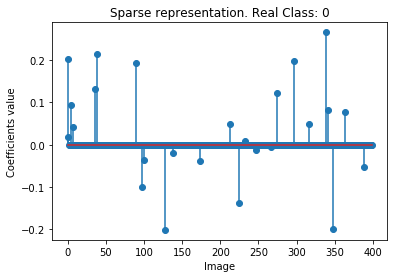

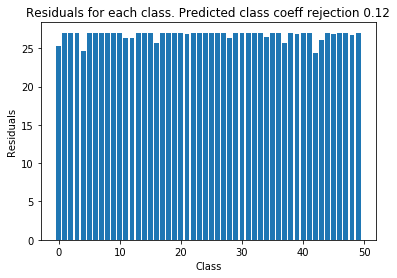

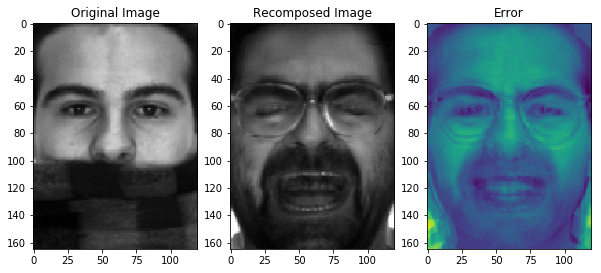

In [49]:
test_pic = 1


FaceClass(test_pic,0.9)

In [50]:
#liste = []

#for alpha in range(1,100,1):
#    alpha = alpha/100
total = 0

for i in range(Xtest.shape[1]):
    #res = FaceClass_noplot(i,alpha)
    res = FaceClass_noplot(i,0.01)
    if res == 'Good Prediction':
        total+=1
        
print('Test Score : %s' %(total/(Xtest.shape[1]))) 
#    tot = total/(Xtest.shape[1])
#    liste.append(tot)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test Score : 0.4


40 % success with only the scarf, 25,3 % if we add the scarf pictures with different lighting. Still not good, that means one picture out of four is recognized, let's see what wrong pictures look like :

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test class:  49
Predicted class:  37
SCI:  0.10952513766046656
Test class:  49
Predicted class:  20
SCI:  0.06829340799845159


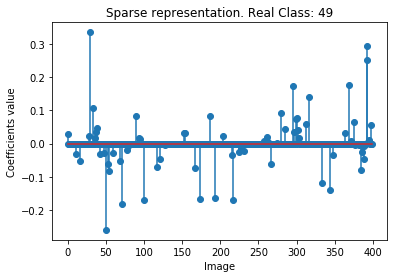

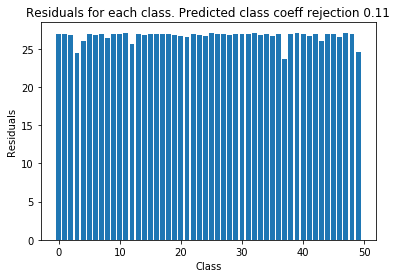

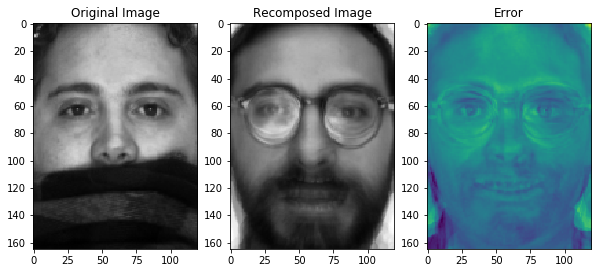

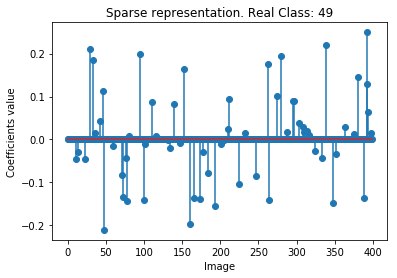

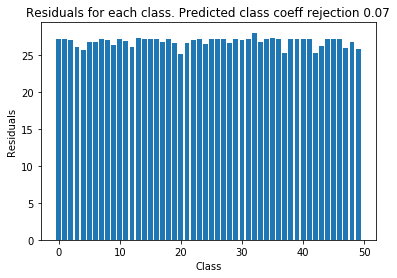

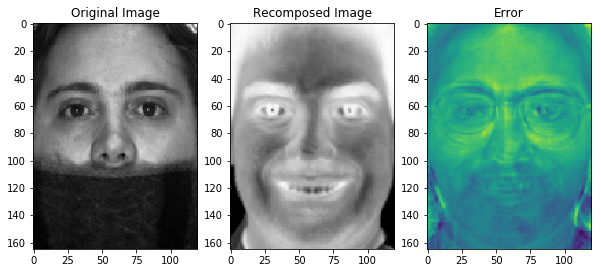

In [51]:
for i in range(Xtest.shape[1]):
    if (i in range(90,101)) or (i in range(190,201)):
        res = FaceClass_noplot(i,0.01)
        if res != 'Good Prediction':
            FaceClass(i,0.01)

Conclusion : people with beards are chosen every time, just like in the article ! Subject 37 gets picked a lot for example. Since that subject has glasses, test images with glasses and a scarf are assigned subject 37.

When we look at those well classified, we realise that they usually have a special feature. For example, every one with a beard is well recognized, so are people with glasses. But there's also an Asian person that is well recognized, probably because he's the only one in the database, just like men with a darker skin color, which are indeed fewer.

# Adding Noise

Here we will add noise to our test image and see if the classification is good or not. Pictures are recognised up to 65% of the test image with noise.

In [52]:
def noise_image(image_input, per=0.5):
    '''
    Adding noise thanks to the variable per, 
    for percentage of pixels to corrupt
    '''
    sz0 = image_input.shape[0]
    sz1 = image_input.shape[1]
    
    nb_pix_to_noise = int(np.floor(per*sz0*sz1))
    
    mask = np.ones((sz0*sz1,1))
    ids = np.random.permutation(sz0*sz1)[0:nb_pix_to_noise]
    mask[ids] = 0
    mask = np.reshape(mask,(sz0,sz1))
    
    # chosing random pixels
    rand_pix = np.random.randint(0,256,size=(sz0,sz1))

    return np.multiply(mask,image_input) + np.multiply(1-mask,rand_pix)
    

### Build the dataset

In [53]:
if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images(path_images, sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images(path_images, sz=(30,42))
else :
    X, y = read_images(path_images, sz=(30,42))

Images uploaded !


In [54]:
X_train, X_test  = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if (i%26 in range(1,5)) or (i%26 in range(14,18)) : # condition on i for the train images
        X_train.append(X[i])
        ytrain.append(y[i])
        indices_train.append(i)
    else:
        X_test.append(X[i])
        ytest.append(y[i])
        indices_test.append(i)

In [55]:
X_test_noise = []
X_train_noise = []
noise=0.60

for i in range(len(X_test)):
    tmp = noise_image(X_test[i],noise)
    im = Image.fromarray(tmp)
    #im = im.resize([96,84], Image.NEAREST)     
    X_test_noise.append(np.asarray(im, dtype=np.uint8))
        
        
for i in range(len(X_train)):
    im = Image.fromarray(X_train[i])
    #im = im.resize([96,84], Image.NEAREST)     
    X_train_noise.append(np.asarray(im, dtype=np.uint8))

In [56]:
test_pic = 55

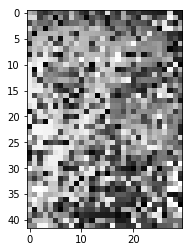

In [57]:
tmp = noise_image(X_test[test_pic],noise)
plt.imshow(tmp,cmap='gray')
im = Image.fromarray(tmp)
#im = im.resize((96,84), Image.NEAREST)

Xtrain, Xtest = stack(X_train_noise, X_test_noise)

### Fit

In [58]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.fit_transform(Xtest)

Xtrain2 = np.concatenate([Xtrain,np.eye(X_train[0].shape[0]*X_train[0].shape[1])],axis=1)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [59]:
y = Xtest[:,test_pic]

In [60]:
clf = Lasso(alpha=0.2)

clf.fit(Xtrain2,y)
x = clf.coef_
pred_class = np.argmin(residual(Xtest[:,test_pic],Xtrain,x[:len(ytrain)],ytrain))
print('Predicted Class: %s' %pred_class)

Predicted Class: 46


Text(0.5,0,'Image')

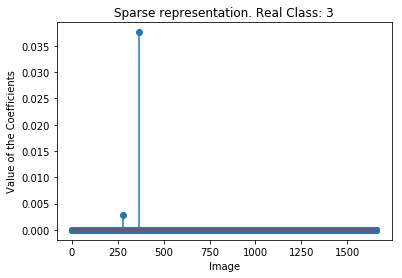

In [61]:
plt.figure()
plt.stem(x)
plt.title('Sparse representation. Real Class: ' + str(ytest[test_pic]))
plt.ylabel('Value of the Coefficients')
plt.xlabel('Image')

The sparse representation is very clear on the frontal images, but gets less sparse as we change lighting and add sunglasses or scarfs to the subjects.

# Random Image

We check here that a random image found on the internet has a low SCI.

In [62]:
if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images(path_images, sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images(path_images, sz=(30,42))
else :
    X, y = read_images(path_images, sz=(30,42))

Images uploaded !


In [63]:
X_train, X_test  = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if (i%26 in range(1,5)) or (i%26 in range(14,18)) : # condition on i for the train images
        X_train.append(X[i])
        ytrain.append(y[i])
        indices_train.append(i)
    else:
        X_test.append(X[i])
        ytest.append(y[i])
        indices_test.append(i)

Text(0.5,1,'Looks like a face')

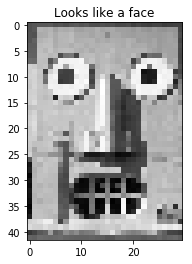

In [64]:
im = Image.open("C:/Users/User/Documents/Compressed Sensing/Pics/Maybe_a_face.jpg") 
im = im.convert("L")
im = im.resize((30,42), Image.NEAREST)     
X_bad = np.asarray(im, dtype=np.uint8)

plt.figure()
plt.clf()
plt.imshow(X_bad, cmap='gray')
plt.title('Looks like a face')

In [65]:
clf = Lasso(alpha=0.28)

y = np.reshape(X_bad,(30*42,1))

clf.fit(Xtrain,y)
x = clf.coef_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [66]:
pred_class = np.argmin(residual(Xtest[:,test_pic],Xtrain,x,ytrain))

In [67]:
print("Real class: ", ytest[test_pic])
print("Predicted class: ", pred_class)
print("SCI : ", SCI(x,ytrain))

Real class:  3
Predicted class:  9
SCI :  0.044556998327100916


Text(0.5,0,'Image')

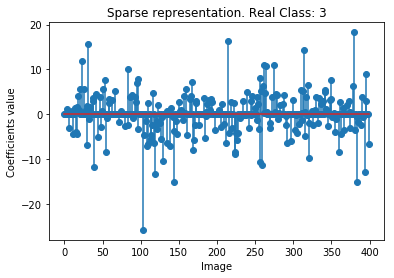

In [68]:
plt.figure()
plt.stem(x)
plt.title('Sparse representation. Real Class: ' + str(ytest[test_pic]))
plt.ylabel('Coefficients value')
plt.xlabel('Image')

Text(0.5,0,'Class')

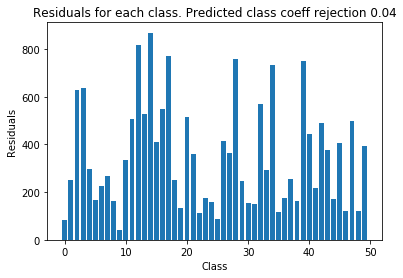

In [69]:
plt.figure()
plt.clf()
plt.bar(range(50),residual(Xtest[:,test_pic],Xtrain,x,ytrain))
plt.title('Residuals for each class. Predicted class coeff rejection ' + str(np.round(SCI(x,ytrain),2)))
plt.ylabel('Residuals')
plt.xlabel('Class')

As a conclusion, SCI is a good indicator. The coefficients are very spread out ! With an SCI of only 0.04